In [6]:
#@title Import required libraries
import argparse
import itertools
import math
import os
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.hub_utils import init_git_repo, push_to_hub
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

pretrained_model_name_or_path = "CompVis/stable-diffusion-v1-4"

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        im = img.resize((w//4, h//4))
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        img = img.resize((w, h))
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

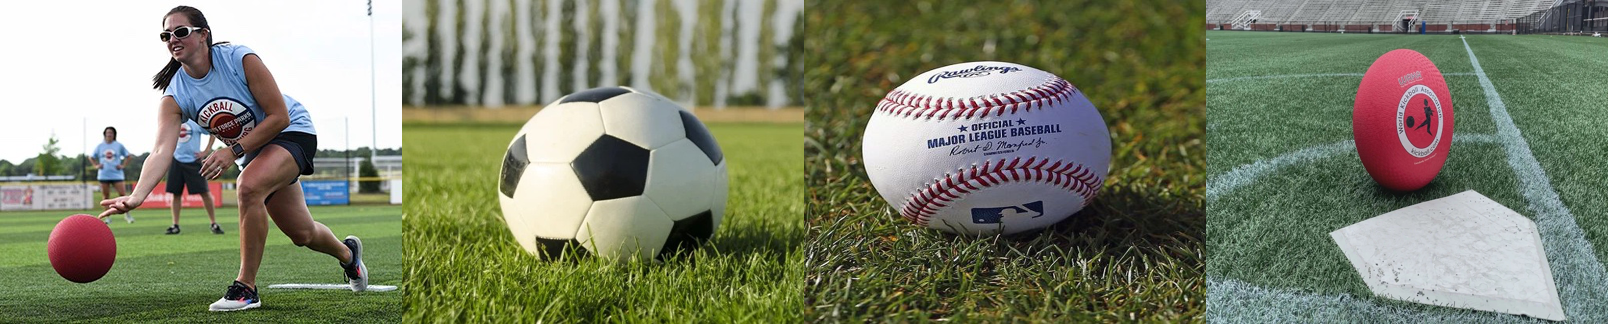

In [7]:
from torchvision.datasets.folder import default_loader
directory = 'ball_pics'


def convert_rgb(img):
  return default_loader(img)

images = []
for i in os.listdir(directory):
  images.append(convert_rgb(directory + '/' + i))

image_grid(images, 1, len(images))


In [29]:
#@title Settings for your newly created concept
#@markdown `what_to_teach`: what is it that you are teaching? `object` enables you to teach the model a new object to be used, `style` allows you to teach the model a new style one can use.
what_to_teach = "object" #@param ["object", "style"]
#@markdown `placeholder_token` is the token you are going to use to represent your new concept (so when you prompt the model, you will say "A `<my-placeholder-token>` in an amusement park"). We use angle brackets to differentiate a token from other words/tokens, to avoid collision.
placeholder_token1 = "<shape>" #@param {type:"string"}
placeholder_token2 = "<color>" #@param {type:"string"}
#@markdown `initializer_token` is a word that can summarise what your new concept is, to be used as a starting point
initializer_token1 = "shape" #@param {type:"string"}
initializer_token2 = "color" #@param {type:"string"}

#@title Setup the prompt templates for training 
#@title Setup the prompt templates for training 
imagenet_templates_small = [
    "a photo of a {} shape with the color {}",
    "a rendering of a {} shape with the color {}",
    "a cropped photo of a {} shape with the color {}",
    "the photo of a {} shape with the color {}",
    "a photo of a clean {} shape with the color {}",
    "a photo of a dirty {} shape with the color {}",
    "a dark photo of a {} shape with the color {}",
    "a photo of a {} shape with the color {}",
    "a close-up photo of a {} shape with the color {}",
    "a bright photo of a {} shape with the color {}",
    "a good photo of a {} shape with the color {}",
    "a photo of one {} shape with the color {}",
    "a close-up photo of a {} shape with the color {}",
    "a rendition of a {} shape with the color {}",
    "a photo of a nice {} shape with the color {}",
    "a good photo of a {} shape with the color {}",
    "a photo of a weird {} shape with the color {}",
    "a photo of a large {} shape with the color {}",
    "a photo of a cool {} shape with the color {}",
    "a photo of a small {} shape with the color {}",
]

custom_templates = {'soccer':
        [
            "A photo of a {} object on green grass",
            "A photo of a nice {} object on green grass",
            "a bright photo of a {} shape",
            "a close-up photo of a {} object with the color white and black",
            "a good photo of a {} object",
            "A photo of a {} object with a checkered pattern",
            "a rendering of a {} shape",
            
        ],
    'basbeall':
    [
        "A photo of a {} object on green grass",
        "A photo of a nice {} object on green grass",
        "a bright photo of a {} shape",
        "a close-up photo of a {} object with the color white and {}",
        "a good photo of a {} object",
         "a rendering of a {} shape",
    ],
    'adult_kickball':
    [
        "A photo of a {} object on green grass",
        "A photo of a nice {} object on green grass",
        "a bright photo of a {} shape",
        "a close-up photo of a {} object with the color {}",
        "a good photo of a {} object that has the color {}",
         "a rendering of a {} shape with the color {}",
    ],
    'kickball':
    [
        "A photo of a {} object on green grass",
        "A photo of a nice {} object on green grass",
        "a bright photo of a {} shape",
        "a close-up photo of a {} object with the color {}",
        "a good photo of a {} object that has the color {}",
         "a rendering of a {} shape with the color {}",
    ]}

In [40]:
#@title Setup the dataset
class TextualInversionDataset(Dataset):
    def __init__(
        self,
        data_root,
        tokenizer,
        learnable_property="object",  # [object, style]
        size=512,
        repeats=100,
        interpolation="bicubic",
        flip_p=0.5,
        set="train",
        placeholder_token1="*",
        placeholder_token2="<<<",
        center_crop=False,
    ):

        self.data_root = data_root
        self.tokenizer = tokenizer
        self.learnable_property = learnable_property
        self.size = size
        self.placeholder_token1 = placeholder_token1
        self.placeholder_token2 = placeholder_token2
        self.center_crop = center_crop
        self.flip_p = flip_p

        self.image_paths = [os.path.join(self.data_root, file_path) for file_path in os.listdir(self.data_root)]

        self.num_images = len(self.image_paths)
        self._length = self.num_images

        if set == "train":
            self._length = self.num_images * repeats

        self.interpolation = {
            "linear": PIL.Image.LINEAR,
            "bilinear": PIL.Image.BILINEAR,
            "bicubic": PIL.Image.BICUBIC,
            "lanczos": PIL.Image.LANCZOS,
        }[interpolation]

        self.templates = custom_templates
        self.flip_transform = transforms.RandomHorizontalFlip(p=self.flip_p)

    def __len__(self):
        return self._length

    def __getitem__(self, i):
        example = {}
        image_path = self.image_paths[i % self.num_images]
        name = image_path.split('/')[1].split('.')[0]
        image = Image.open(image_path)

        if not image.mode == "RGB":
            image = image.convert("RGB")


        placeholder_string1 = self.placeholder_token1
        placeholder_string2 = self.placeholder_token2
        text = random.choice(self.templates[name])
        text = text.format(placeholder_string1, placeholder_string2)
        example['text'] = text

        example["input_ids"] = self.tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
            return_tensors="pt",
        ).input_ids[0]

        # default to score-sde preprocessing
        img = np.array(image).astype(np.uint8)

        if self.center_crop:
            crop = min(img.shape[0], img.shape[1])
            h, w, = (
                img.shape[0],
                img.shape[1],
            )
            img = img[(h - crop) // 2 : (h + crop) // 2, (w - crop) // 2 : (w + crop) // 2]

        image = Image.fromarray(img)
        image = image.resize((self.size, self.size), resample=self.interpolation)

        image = self.flip_transform(image)
        image = np.array(image).astype(np.uint8)
        image = (image / 127.5 - 1.0).astype(np.float32)

        example["pixel_values"] = torch.from_numpy(image).permute(2, 0, 1)
        return example

In [42]:
dataset = TextualInversionDataset('ball_pics/',
                            None,)
dataset[0]

a bright photo of a {} shape
a bright photo of a * shape


╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /tmp/ipykernel_17706/2457003540.py:3 in <cell line: 3>                                    │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_17706/2457003540.py'                 │
│ /tmp/ipykernel_17706/1087533325.py:70 in __getitem__                                      │
│                                                                                           │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_17706/1087533325.py'                 │
╰───────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'NoneType' object has no attribute 'model_max_length'

In [5]:
#@title Load the tokenizer and add the placeholder token as a additional special token.
#@markdown Please read and if you agree accept the LICENSE [here](https://huggingface.co/CompVis/stable-diffusion-v1-4) if you see an error
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)

# Add the placeholder token in tokenizer
num_added_tokens = tokenizer.add_tokens(placeholder_token1)
num_added_tokens += tokenizer.add_tokens(placeholder_token2)
if num_added_tokens < 2:
    raise ValueError(
        f"The tokenizer already contains the token {placeholder_token1}. Please pass a different"
        " `placeholder_token` that is not already in the tokenizer."
    )
    
token_ids1 = tokenizer.encode(initializer_token1, add_special_tokens=False)
token_ids2 = tokenizer.encode(initializer_token2, add_special_tokens=False)
# Check if initializer_token is a single token or a sequence of tokens
if len(token_ids1) > 1:
    raise ValueError("The initializer token must be a single token.")

initializer_token_id1 = token_ids1[0]
placeholder_token_id1 = tokenizer.convert_tokens_to_ids(placeholder_token1)
initializer_token_id2 = token_ids2[0]
placeholder_token_id2 = tokenizer.convert_tokens_to_ids(placeholder_token2)


#@title Load the Stable Diffusion model
# Load models and create wrapper for stable diffusion
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet"
)
text_encoder.resize_token_embeddings(len(tokenizer))
token_embeds = text_encoder.get_input_embeddings().weight.data
token_embeds[placeholder_token_id1] = token_embeds[initializer_token_id1]
token_embeds[placeholder_token_id2] = token_embeds[initializer_token_id2]

In [6]:
def freeze_params(params):
    for param in params:
        param.requires_grad = False

# Freeze vae and unet
freeze_params(vae.parameters())
freeze_params(unet.parameters())
# Freeze all parameters except for the token embeddings in text encoder
params_to_freeze = itertools.chain(
    text_encoder.text_model.encoder.parameters(),
    text_encoder.text_model.final_layer_norm.parameters(),
    text_encoder.text_model.embeddings.position_embedding.parameters(),
)
freeze_params(params_to_freeze)

In [7]:
train_dataset = TextualInversionDataset(
      data_root=directory,
      tokenizer=tokenizer,
      size=512,
      placeholder_token1=placeholder_token1,
      placeholder_token2=placeholder_token2,
      repeats=100,
      learnable_property=what_to_teach, #Option selected above between object and style
      center_crop=False,
      set="train",
)
def create_dataloader(train_batch_size=1):
    return torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)

noise_scheduler = DDPMScheduler(
    beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000, tensor_format="pt"
)

hyperparameters = {
    "learning_rate": 5e-04,
    "scale_lr": True,
    "max_train_steps": 3000,
    "train_batch_size": 1,
    "gradient_accumulation_steps": 4,
    "seed": 42,
    "output_dir": "red-ball-concept"
}

In [10]:
def training_function(text_encoder, vae, unet):
    logger = get_logger(__name__)

    train_batch_size = hyperparameters["train_batch_size"]
    gradient_accumulation_steps = hyperparameters["gradient_accumulation_steps"]
    learning_rate = hyperparameters["learning_rate"]
    max_train_steps = hyperparameters["max_train_steps"]
    output_dir = hyperparameters["output_dir"]

    accelerator = Accelerator(
        gradient_accumulation_steps=gradient_accumulation_steps,
    )

    train_dataloader = create_dataloader(train_batch_size)

    if hyperparameters["scale_lr"]:
        learning_rate = (
            learning_rate * gradient_accumulation_steps * train_batch_size * accelerator.num_processes
        )

    # Initialize the optimizer
    optimizer = torch.optim.AdamW(
        text_encoder.get_input_embeddings().parameters(),  # only optimize the embeddings
        lr=learning_rate,
    )


    text_encoder, optimizer, train_dataloader = accelerator.prepare(
        text_encoder, optimizer, train_dataloader
    )

    # Move vae and unet to device
    vae.to(accelerator.device)
    unet.to(accelerator.device)

    # Keep vae and unet in eval model as we don't train these
    vae.eval()
    unet.eval()

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / gradient_accumulation_steps)
    num_train_epochs = math.ceil(max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = train_batch_size * accelerator.num_processes * gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        text_encoder.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(text_encoder):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"]).latent_dist.sample().detach()
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn(latents.shape).to(latents.device)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=latents.device).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                loss = F.mse_loss(noise_pred, noise, reduction="none").mean([1, 2, 3]).mean()
                accelerator.backward(loss)

                # Zero out the gradients for all token embeddings except the newly added
                # embeddings for the concept, as we only want to optimize the concept embeddings
                if accelerator.num_processes > 1:
                    grads = text_encoder.module.get_input_embeddings().weight.grad
                else:
                    grads = text_encoder.get_input_embeddings().weight.grad
                # Get the index for tokens that we want to zero the grads for
                index_grads_to_zero = torch.arange(len(tokenizer)) != placeholder_token_id1 #& torch.arange(len(tokenizer)) != placeholder_token_id2
                index_grads_to_zero[placeholder_token_id2] = False
                grads.data[index_grads_to_zero, :] = grads.data[index_grads_to_zero, :].fill_(0)

                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= max_train_steps:
                break

        accelerator.wait_for_everyone()


    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline(
            text_encoder=accelerator.unwrap_model(text_encoder),
            vae=vae,
            unet=unet,
            tokenizer=tokenizer,
            scheduler=PNDMScheduler(
                beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", skip_prk_steps=True
            ),
            safety_checker=StableDiffusionSafetyChecker.from_pretrained("CompVis/stable-diffusion-safety-checker"),
            feature_extractor=CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32"),
        )
        pipeline.save_pretrained(output_dir)
        # Also save the newly trained embeddings
        learned_embeds1 = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id1]
        learned_embeds2 = accelerator.unwrap_model(text_encoder).get_input_embeddings().weight[placeholder_token_id2]
        learned_embeds_dict = {placeholder_token1: learned_embeds1.detach().cpu(), placeholder_token2: learned_embeds2.detach().cpu()}
        torch.save(learned_embeds_dict, os.path.join(output_dir, "learned_embeds.bin"))

In [11]:
'''import accelerate
accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet), num_processes = 1)'''

'import accelerate\naccelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet), num_processes = 1)'

  0%|          | 0/51 [00:00<?, ?it/s]

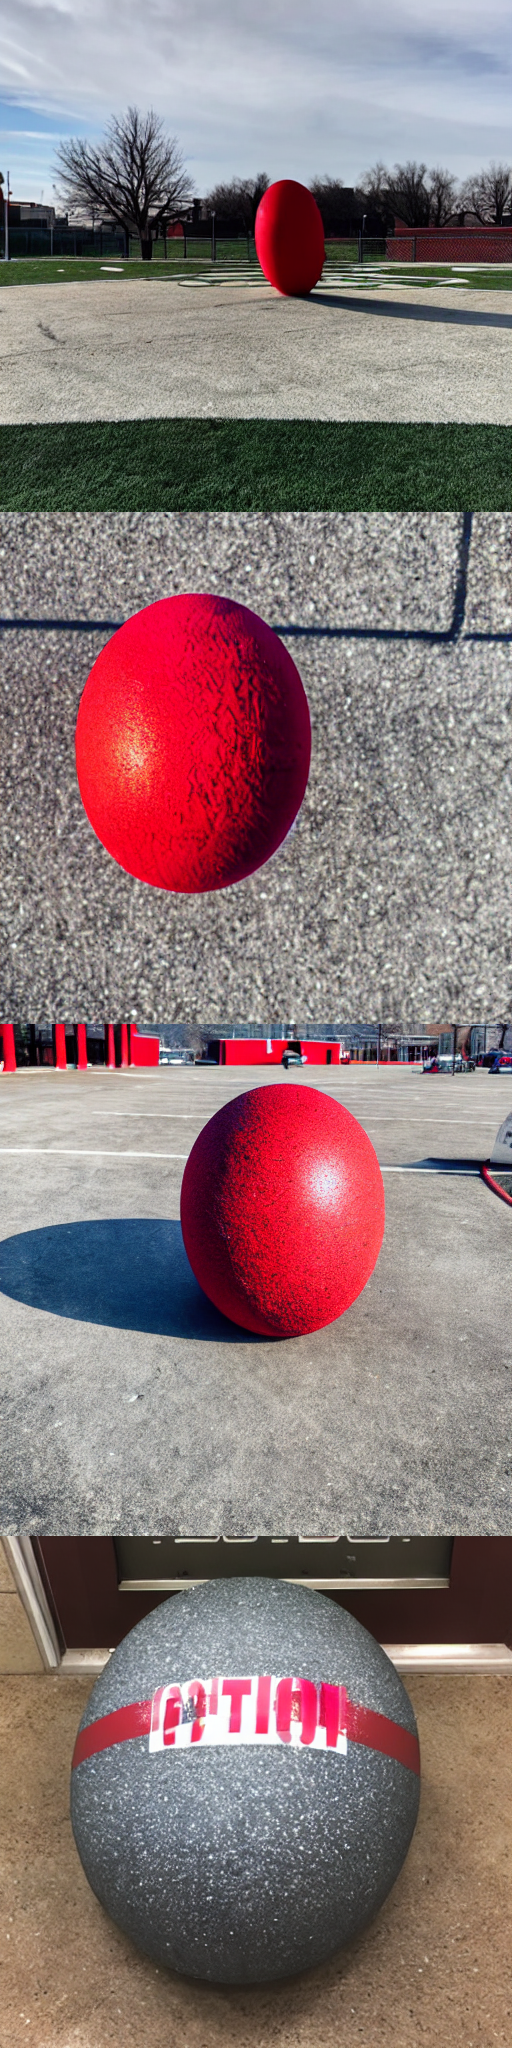

In [22]:
#@title Set up the pipeline 
pipe = StableDiffusionPipeline.from_pretrained(
    hyperparameters["output_dir"],
    torch_dtype=torch.float16,
).to("cuda")

prompt = "a photo of a {} shape with the color {}".format(placeholder_token1, placeholder_token2) #@param {type:"string"}

num_samples = 4 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}

all_images = [] 
for _ in range(num_rows):
    images = pipe([prompt] * num_samples, num_inference_steps=50, guidance_scale=7.5).images
    all_images.extend(images)

grid = image_grid(all_images, num_samples, num_rows)
grid

In [23]:
print('Cosine Distance')
print()
import torch.nn.functional as F
import torch.nn as nn
embeddings = pipe.text_encoder.get_input_embeddings().weight
token_id = pipe.tokenizer.convert_tokens_to_ids(placeholder_token1)
cos = nn.CosineSimilarity(dim=1, eps=1e-3)
output = cos(embeddings[token_id].unsqueeze(dim = 0), embeddings)
val, idx = torch.topk(output, k = 10)
print(val)
print(idx)
for i, index in enumerate(idx):
    print(val[i].item(), pipe.tokenizer.decode([index]))

print()
print()
print()
print('Euclidean Distance')
print()
import torch.nn.functional as F
import torch.nn as nn
embeddings = pipe.text_encoder.get_input_embeddings().weight
token_id = pipe.tokenizer.convert_tokens_to_ids(placeholder_token1)
output = -torch.cdist(embeddings[token_id].unsqueeze(dim = 0), embeddings)
val, idx = torch.topk(output, k = 10)
print(val)
print(idx)
for i, index in enumerate(idx[0]):
    print(val[0][i].item(), pipe.tokenizer.decode([index]))


Cosine Distance

tensor([1.0000, 0.1693, 0.1588, 0.1556, 0.1539, 0.1521, 0.1500, 0.1499, 0.1497,
        0.1494], device='cuda:0', dtype=torch.float16, grad_fn=<TopkBackward0>)
tensor([49408, 36845, 33627, 20529, 43733, 29239, 38952, 15297, 35870, 11267],
       device='cuda:0')
1.0 <shape>
0.1693115234375 📍:
0.1588134765625 criteri
0.1556396484375 msc
0.1539306640625 regression
0.152099609375 springwatch
0.1500244140625 ========
0.14990234375 outreach
0.149658203125 wareness
0.1494140625 🎄



Euclidean Distance

tensor([[-0.0000, -2.7930, -2.7949, -2.7949, -2.7969, -2.7988, -2.7988, -2.7988,
         -2.7988, -2.7988]], device='cuda:0', dtype=torch.float16,
       grad_fn=<TopkBackward0>)
tensor([[49408, 36845, 33627, 20529, 43733, 35870, 38952, 29239, 11267, 15297]],
       device='cuda:0')
-0.0 <shape>
-2.79296875 📍:
-2.794921875 criteri
-2.794921875 msc
-2.796875 regression
-2.798828125 wareness
-2.798828125 ========
-2.798828125 springwatch
-2.798828125 🎄
-2.798828125 outreach


In [11]:
from scipy import spatial
token_id = pipe.tokenizer.convert_tokens_to_ids(placeholder_token)
token_embeds = text_encoder.get_input_embeddings().weight.data.cpu()
color_to_attribute_idx = {'blue': 0,'brown': 1,'iridescent': 2,
                                'purple': 3,'rufous': 4,'grey': 5,
                                'yellow': 6,'olive': 7,'green': 8,
                                'pink': 9,'orange': 10,'black': 11,
                                'white':12 ,'red': 13,'buff': 14}
cosine_sims = []
for i in color_to_attribute_idx:
    new_idx = pipe.tokenizer.convert_tokens_to_ids(i)
    cosine_sim = 1 - spatial.distance.cosine(token_embeds[token_id], token_embeds[new_idx])
    cosine_sims.append([i, cosine_sim])
cosine_sims

[['blue', -0.016612088307738304],
 ['brown', 0.021827993914484978],
 ['iridescent', 0.04960748180747032],
 ['purple', 0.015421131625771523],
 ['rufous', 0.04960748180747032],
 ['grey', 0.006637181155383587],
 ['yellow', -0.0013554865727201104],
 ['olive', 0.01335769984871149],
 ['green', -0.03427588939666748],
 ['pink', -0.0004268811026122421],
 ['orange', 0.03001478873193264],
 ['black', 0.02245166525244713],
 ['white', 0.00278395670466125],
 ['red', 0.018257858231663704],
 ['buff', -0.06917596608400345]]

In [12]:
from scipy import spatial
token_id = pipe.tokenizer.convert_tokens_to_ids(placeholder_token)
token_embeds = text_encoder.get_input_embeddings().weight.data.cpu()
color_to_attribute_idx = {'blue': 0,'brown': 1,'iridescent': 2,
                                'purple': 3,'rufous': 4,'grey': 5,
                                'yellow': 6,'olive': 7,'green': 8,
                                'pink': 9,'orange': 10,'black': 11,
                                'white':12 ,'red': 13,'buff': 14}
euclidean_distances = []
for i in color_to_attribute_idx:
    new_idx = pipe.tokenizer.convert_tokens_to_ids(i)
    euclidean_distance = spatial.distance.euclidean(token_embeds[token_id], token_embeds[new_idx])
    euclidean_distances.append([i, euclidean_distance])
euclidean_distances

[['blue', 0.5581141710281372],
 ['brown', 0.5497653484344482],
 ['iridescent', 1.1448577642440796],
 ['purple', 0.5498030781745911],
 ['rufous', 1.1448577642440796],
 ['grey', 0.5555132627487183],
 ['yellow', 0.5641696453094482],
 ['olive', 0.5344266891479492],
 ['green', 0.5556091070175171],
 ['pink', 0.5459226369857788],
 ['orange', 0.5399313569068909],
 ['black', 0.5415103435516357],
 ['white', 0.5550603866577148],
 ['red', 0.5358379483222961],
 ['buff', 0.5831795334815979]]